Connect GPU and istall fair-esm package for ESM2 usage

In [1]:
import torch
import pandas as pd

!pip install fair-esm -q

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Using device: cuda


# 1. read in dataset

In [2]:
def get_mutated_sequence(mut, sequence_wt):
  wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]

  sequence = deepcopy(sequence_wt)

  return sequence[:pos]+mt+sequence[pos+1:]

def get_pos_sequence(mut):
  wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]

  return pos

In [3]:
with open('Hackathon_data/sequence.fasta', 'r') as f:
  data = f.readlines()

sequence_wt = data[1].strip()


In [4]:
import numpy as np
from copy import deepcopy

df_base = pd.read_csv('Hackathon_data/train.csv')
df_base['mut_seq'] = df_base.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_base['pos'] = df_base.mutant.apply(lambda x: get_pos_sequence(x))
df_base['wt_seq'] = sequence_wt
df_base.loc[:, "score"] = df_base["DMS_score"]

df_train2 = pd.read_csv('Hackathon_data/train2.csv')
df_train2['mut_seq'] = df_train2.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train2['pos'] = df_train2.mutant.apply(lambda x: get_pos_sequence(x))
df_train2['wt_seq'] = sequence_wt
df_train2.loc[:, "score"] = df_train2["DMS_score"]

df_train3 = pd.read_csv('Hackathon_data/train3.csv')
df_train3['mut_seq'] = df_train3.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train3['pos'] = df_train3.mutant.apply(lambda x: get_pos_sequence(x))
df_train3['wt_seq'] = sequence_wt
df_train3.loc[:, "score"] = df_train3["DMS_score"]

df_train4 = pd.read_csv('Hackathon_data/train4.csv')
df_train4['mut_seq'] = df_train4.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train4['pos'] = df_train4.mutant.apply(lambda x: get_pos_sequence(x))
df_train4['wt_seq'] = sequence_wt
df_train4.loc[:, "score"] = df_train4["DMS_score"]

df_test = pd.read_csv('Hackathon_data/test.csv')
df_test['mut_seq'] = df_test.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_test['pos'] = df_test.mutant.apply(lambda x: get_pos_sequence(x))
df_test['wt_seq'] = sequence_wt
df_test.loc[:, "score"] = 0


In [5]:
# concate initial training data and following query data
df_train = pd.concat([df_base, df_train2, df_train3, df_train4], ignore_index=True)

# 2 Define Dataset and Model
this part was referred from https://github.com/moritzgls/ESM-Effect

In [6]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
from typing import Dict, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
import esm


class ProteinDataset(Dataset):
    def __init__(self, df: pd.DataFrame):

        self.df = df
        self._setup_esm()

    def _setup_esm(self):

        _, self.esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.esm_batch_converter = self.esm_alphabet.get_batch_converter()

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        
        
        # Base features
        _, _, esm_batch_tokens1 = self.esm_batch_converter(
            [('', ''.join(row['wt_seq'])[:1022])])
        _, _, esm_batch_tokens2 = self.esm_batch_converter(
            [('', ''.join(row['mut_seq'])[:1022])])
        
        tokens1 = esm_batch_tokens1[0]
        tokens2 = esm_batch_tokens2[0]
        
        pos = torch.tensor(row['pos'], dtype=torch.long)
        length = torch.tensor(len(row['wt_seq']), dtype=torch.long)
    

        # position and length features
        features = [
            tokens1,
            tokens2,
            row['pos'],
            len(row["wt_seq"]),
        ]

        # Target
        features.append(
            torch.unsqueeze(torch.FloatTensor([row['score']]), 0)
        )

        return tuple(features)

    def __len__(self):
        return len(self.df)

Define an ESM-finetuning model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from collections import defaultdict

class ESMEffect(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()

        self.freeze_up_to = 31

        self.esm2mut, _ = esm.pretrained.esm2_t33_650M_UR50D()

        # Freeze layers up to the 31th layer
        for i in range(self.freeze_up_to):
            for param in self.esm2mut.layers[i].parameters():
                param.requires_grad = False

        self.n_layers = 33
        embedding_dim = 1280

        # Cache for embeddings from the first 31 layers
        self.embedding_cache = defaultdict(torch.Tensor)

        # Regression head
        self.dropout = nn.Dropout(dropout_rate)
        self.regressor = nn.Linear(embedding_dim, 1)


    def forward(self, token_wt, token_mut, pos, lengths):
        batch_size = token_mut.size(0)
        cached_mut_embeddings = []

        for i in range(batch_size):
            seq_mut_id = token_mut[i].tolist() 
            seq_wt_id = token_wt[i].tolist()
            if tuple(seq_mut_id) in self.embedding_cache:
                # Use cached embedding
                cached_mut_embeddings.append(self.embedding_cache[tuple(seq_mut_id)])
            else:
                # Generate new mutant embedding and cache it
                with torch.no_grad():
                    x = self.esm2mut(token_mut[i].unsqueeze(0), [self.n_layers-2])
                embedding = x['representations'][self.n_layers-2]
                self.embedding_cache[tuple(seq_mut_id)] = embedding.detach() 
                cached_mut_embeddings.append(embedding)
            

        # Stack cached embeddings for the batch
        mut = torch.cat(cached_mut_embeddings, dim=0)

        # Pass mutant embedding through 32th and 33th layers
        mut, _ = self.esm2mut.layers[self.n_layers-2](mut)
        mut, _ = self.esm2mut.layers[self.n_layers-1](mut)
        mut = self.esm2mut.emb_layer_norm_after(mut)
        
        # Extract the embedding corresponding to the mutated residue
        x = []
        for i in range(batch_size):

            position =  mut[i, pos[i]+1, :]
            x.append(position)

        x = torch.stack(x).squeeze(1)

        # Feed through the regression head
        predictions = self.regressor(self.dropout(x))
        return predictions
    
    
def setup_optimizer_and_scheduler_esmeffect(model, train_loader, epochs, batch_size, lr_for_esm, lr_for_head):

    # Define learning rates
    lr_esm =  batch_size * lr_for_esm  # Lower learning rate for pre-trained ESM2 layers
    lr_new =  batch_size * lr_for_head  # Higher learning rate for new layers (regression head)

    # Group parameters
    esm_params = list(model.esm2mut.parameters())
    new_params = (
        list(model.regressor.parameters())
    )

    # Create parameter groups with different learning rates
    param_groups = [
        {'params': esm_params, 'lr': lr_esm},
        {'params': new_params, 'lr': lr_new}
    ]

    # Initialize the optimizer with parameter groups
    optimizer = AdamW(param_groups, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

    # Create the scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=[lr_esm, lr_new],  # Specify max_lr for each group
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    return optimizer, scheduler

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from scipy.stats import spearmanr
from torch.amp import autocast, GradScaler



scaler = GradScaler('cuda')


def train_one_epoch(model, loader, optimizer, criterion, device):
    
    model.train()
    total_loss = 0
    
    for batch in loader:
        batch = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
        inputs, labels = batch[:-1], batch[-1].float()
        
        with autocast('cuda'):
            optimizer.zero_grad()
            predictions = model(*inputs)
            loss = pairwise_ranking_loss(predictions, labels.squeeze(2))
        
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update() 
    
            scheduler.step()
            
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
            inputs, labels = batch[:-1], batch[-1].float()
            
            with autocast('cuda'):
                predictions = model(*inputs)
                loss = pairwise_ranking_loss(predictions, labels.squeeze(2))
                
            total_loss += loss.item()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    all_preds = np.squeeze(all_preds)
    all_labels = np.squeeze(all_labels)
            
            
    metrics = {
        f"loss": total_loss / len(loader),
        f"spearman": spearmanr(all_labels, all_preds)[0],
    }
    
    return metrics

def predict(model, dataframe, config,device):
    model.eval()
    dataset = ProteinDataset(dataframe)
    loader = DataLoader(dataset, batch_size=8, num_workers=config['num_workers'],shuffle=False)
    
    
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
            preds = model(*batch[:-1])  # Exclude labels
            all_preds.extend(preds.cpu().numpy())
            
    predicts = np.squeeze(all_preds)
    
    return predicts


# 3 Training

Set up a Training Run

In [9]:
from sklearn.model_selection import KFold
import torch.nn.functional as F

# Configuration
config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 32,
    'epochs': 30,
    'criterion': 'MSELoss',
    'lr_esm': 1e-5,
    'lr_head': 1e-4,
    'num_workers': 4,
    'feature_columns': []  # Add or remove features as needed (experimental feature, column must be present in dataset)
}

# use pairwise ranking as training loss
def pairwise_ranking_loss(preds, targets, margin=1.0):
    """
    preds: Tensor of shape (B, 1) – predicted DMS scores
    targets: Tensor of shape (B, 1) – true DMS scores
    """
    preds = preds.squeeze() 
    targets = targets.squeeze()
    diff_target = targets.unsqueeze(0) - targets.unsqueeze(1)
    diff_pred = preds.unsqueeze(0) - preds.unsqueeze(1)
    target_sign = torch.sign(diff_target)
    loss_matrix = F.relu(-target_sign * diff_pred + margin)
    mask = torch.eye(len(targets), dtype=torch.bool, device=targets.device)
    loss_matrix = loss_matrix[~mask].view(len(targets), -1)
    return loss_matrix.mean()


In [10]:
import os
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit



save_dir = "saved_models0.5-650M00"
os.makedirs(save_dir, exist_ok=True)

k=5
gss = GroupShuffleSplit(n_splits=k, test_size=0.2, random_state=None)
positions = df_train['pos']
val_spearmans = []
early_stop_patience = 5

for fold, (train_idx, val_idx) in enumerate(gss.split(df_train, groups=positions)):
    print(f"\n===== Fold {fold + 1}/{k} =====")
    df_train_cv = df_train.iloc[train_idx].reset_index(drop=True)
    df_val_cv = df_train.iloc[val_idx].reset_index(drop=True)
    
    train_dataset = ProteinDataset(df_train_cv)
    valid_dataset = ProteinDataset(df_val_cv)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        shuffle=True,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        shuffle=False,
    )


    model = ESMEffect(dropout_rate=0.5).to(device)
    optimizer, scheduler = setup_optimizer_and_scheduler_esmeffect(model, train_loader, config['epochs'],
    config['batch_size'], config['lr_esm'], config['lr_head'])
    criterion = nn.MSELoss()

    best_val_metric = -float('inf')
    epochs_since_improvement = 0

    for epoch in range(config['epochs']):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_metric = evaluate(model,valid_loader, criterion, device)
        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val loss:{val_metric['loss']:.4f} | Val Spearman: {val_metric['spearman']:.4f}")

        if val_metric['spearman'] > best_val_metric:
            best_val_metric = val_metric['spearman']
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_fold{fold + 1}.pt"))
            print(f"New best Spearman: {best_val_metric:.4f} — Model saved.")
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            
        if epochs_since_improvement >= early_stop_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
            
            
    
    
    val_spearmans.append(best_val_metric)
    print(f"Fold {fold + 1} Best_Spearman: {best_val_metric:.4f}")
    
print("\n===== Cross-Validation Complete =====")
print(f"Mean Spearman: {np.mean(val_spearmans):.4f}")
print(f"Std Spearman: {np.std(val_spearmans):.4f}")
    


===== Fold 1/5 =====


/home/hice1/yshen476/.conda/envs/torch/lib/python3.9/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/home/hice1/yshen476/.conda/envs/torch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[Epoch 0] Train Loss: 0.9779 | Val loss:0.9956 | Val Spearman: 0.3413
New best Spearman: 0.3413 — Model saved.
[Epoch 1] Train Loss: 0.9192 | Val loss:0.9844 | Val Spearman: 0.3741
New best Spearman: 0.3741 — Model saved.
[Epoch 2] Train Loss: 0.8132 | Val loss:0.9618 | Val Spearman: 0.3993
New best Spearman: 0.3993 — Model saved.
[Epoch 3] Train Loss: 0.6913 | Val loss:0.9182 | Val Spearman: 0.4169
New best Spearman: 0.4169 — Model saved.
[Epoch 4] Train Loss: 0.6404 | Val loss:0.8963 | Val Spearman: 0.4437
New best Spearman: 0.4437 — Model saved.
[Epoch 5] Train Loss: 0.6302 | Val loss:0.8871 | Val Spearman: 0.4444
New best Spearman: 0.4444 — Model saved.
[Epoch 6] Train Loss: 0.6346 | Val loss:0.8680 | Val Spearman: 0.4259
[Epoch 7] Train Loss: 0.6179 | Val loss:0.8706 | Val Spearman: 0.4285
[Epoch 8] Train Loss: 0.6027 | Val loss:0.8629 | Val Spearman: 0.4473
New best Spearman: 0.4473 — Model saved.
[Epoch 9] Train Loss: 0.6024 | Val loss:0.8464 | Val Spearman: 0.4533
New best Spea

# 4 Testing

In [12]:
# load test set predictions from all 5 folds
all_preds = []
for fold in range(1,6):
    print(f"Loading model from Fold {fold}...")
    model = ESMEffect(dropout_rate=0.5).to(device) 
    model.load_state_dict(torch.load(f"{save_dir}/best_model_fold{fold}.pt"))
    preds = predict(model, df_test, config, device=device)
    all_preds.append(preds)

Loading model from Fold 1...
Loading model from Fold 2...
Loading model from Fold 3...
Loading model from Fold 4...
Loading model from Fold 5...


In [13]:
# Get the mean of all 5 folds prediction
all_preds = np.array(all_preds)
mean_preds = np.mean(all_preds, axis=0) 
std_preds = np.std(all_preds, axis=0)

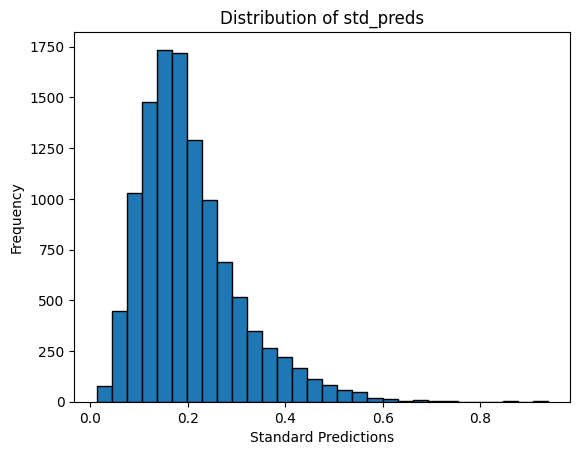

In [14]:
import matplotlib.pyplot as plt
# plot standard error of predictions
plt.hist(std_preds, bins=30, edgecolor='black')
plt.xlabel('Standard Predictions')
plt.ylabel('Frequency')
plt.title('Distribution of std_preds')
plt.show()


In [15]:
df_test['DMS_score_predicted'] = mean_preds
df_test['std'] = std_preds

In [16]:
df_test[['mutant', 'DMS_score_predicted']].to_csv('ESM2_finetuend_predictions.csv',index=False)

# 5 (Optional) Make new queries

In [ ]:
# we can use uncertainty sampling for new queries
top100_indices = np.argsort(std_preds)[-100:]
mutants = [df_test.iloc[i]['mutant'] for i in topk_indices]

# Write to a .txt file
with open('query.txt', 'w') as f:
    for mutant in mutants:
        f.write(mutant+'\n')